In [1]:
import numpy as np
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import os

In [2]:
import mysql.connector
import pandas as pd

db_connection = mysql.connector.connect(
  host="",
  user="",
  passwd="",
  database="mps_data"
)
cursor = db_connection.cursor()

query = '''
SELECT
       DATE_FORMAT(date_time, '%Y-%m-%d 00:00:00') as day, 
       b.borough as borough,
       COUNT(*) as count
FROM use_of_force u
INNER JOIN borough_dict b ON u.borough_id = b.id
WHERE date_time > '2019-01-01 00:00:00' AND PrimaryConduct > 0
GROUP BY day, b.borough;
'''
time_series_daily = pd.read_sql(query, db_connection)

time_series_daily = time_series_daily.sort_values(by=['day'])
time_series_daily['day'] = pd.to_datetime(time_series_daily['day'])

query = '''
SELECT
       DATE_FORMAT(date_time, '%Y-%m-%d %H:00:00') as hour, 
       b.borough as borough,
       COUNT(*) as count
FROM use_of_force u
INNER JOIN borough_dict b ON u.borough_id = b.id
WHERE date_time > '2019-01-01 00:00:00' AND PrimaryConduct > 0
GROUP BY hour, b.borough;
'''
time_series_hourly = pd.read_sql(query, db_connection)

time_series_hourly = time_series_hourly.sort_values(by=['hour'])
time_series_hourly['hour'] = pd.to_datetime(time_series_hourly['hour'])

C:\Users\ggnik\AppData\Local\Temp\ipykernel_4476\2695196086.py:22: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  time_series_daily = pd.read_sql(query, db_connection)
C:\Users\ggnik\AppData\Local\Temp\ipykernel_4476\2695196086.py:37: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  time_series_hourly = pd.read_sql(query, db_connection)


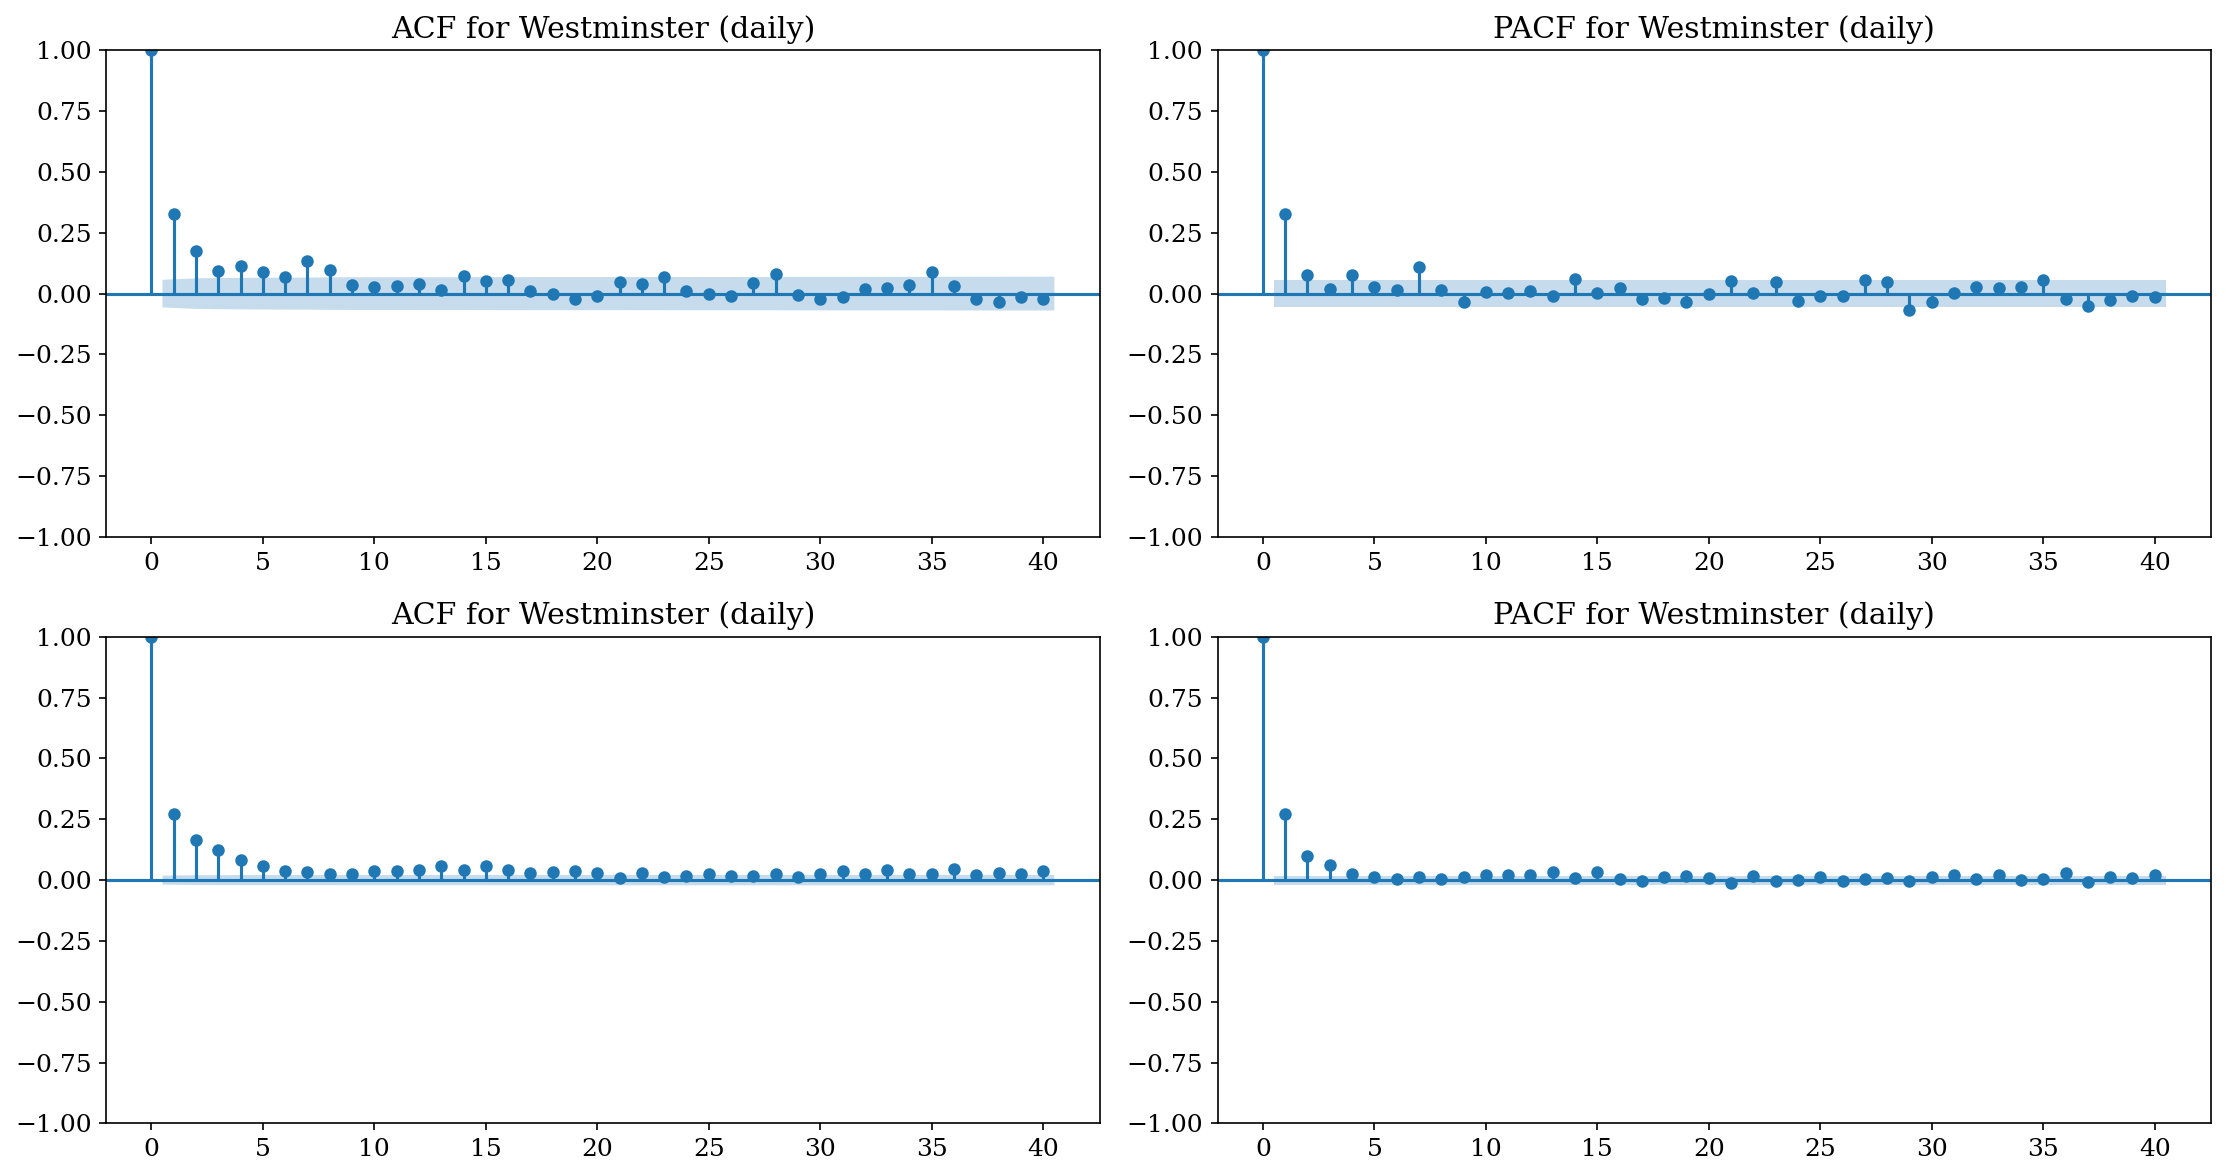

In [3]:
#sort the boroughs by total count of observations
total_counts = time_series_daily.groupby('borough')['count'].sum()
sorted_boroughs = total_counts.sort_values(ascending=False).index.tolist()

os.makedirs("assets", exist_ok=True)
#initialize i
i = 0

#plotting the ACF and PACF for each borough for both daily and hourly granularity
for borough in sorted_boroughs:
    df_daily = time_series_daily[time_series_daily['borough'] == borough].set_index('day')
    df_hourly = time_series_hourly[time_series_hourly['borough'] == borough].set_index('hour')

    fig, ax = plt.subplots(2, 2, figsize=(15, 8), dpi=150)
    #Auto Correlation Function for daily granularity
    sm.graphics.tsa.plot_acf(df_daily['count'], lags=40, ax=ax[0, 0])
    ax[0, 0].set_title(f"ACF for {borough} (daily)")
    #Partial Auto Correlation Function for daily granularity
    sm.graphics.tsa.plot_pacf(df_daily['count'], lags=40, ax=ax[0, 1])
    ax[0, 1].set_title(f"PACF for {borough} (daily)")
    #Auto Correlation Function for hourly granularity
    sm.graphics.tsa.plot_acf(df_hourly['count'], lags=40, ax=ax[1, 0])
    ax[1, 0].set_title(f"ACF for {borough} (daily)")
    #Partial Auto Correlation Function for hourly granularity
    sm.graphics.tsa.plot_pacf(df_hourly['count'], lags=40, ax=ax[1, 1])
    ax[1, 1].set_title(f"PACF for {borough} (daily)")
    
    plt.tight_layout()
    
    #save the plot
    plt.savefig(f"assets/ACF_PACF_{borough}_{i}.png")
    
    #display the plot only for the first iteration
    if i == 0:
        plt.show()
    else:
        #close the plot for subsequent iterations
        plt.close()
    
    i += 1

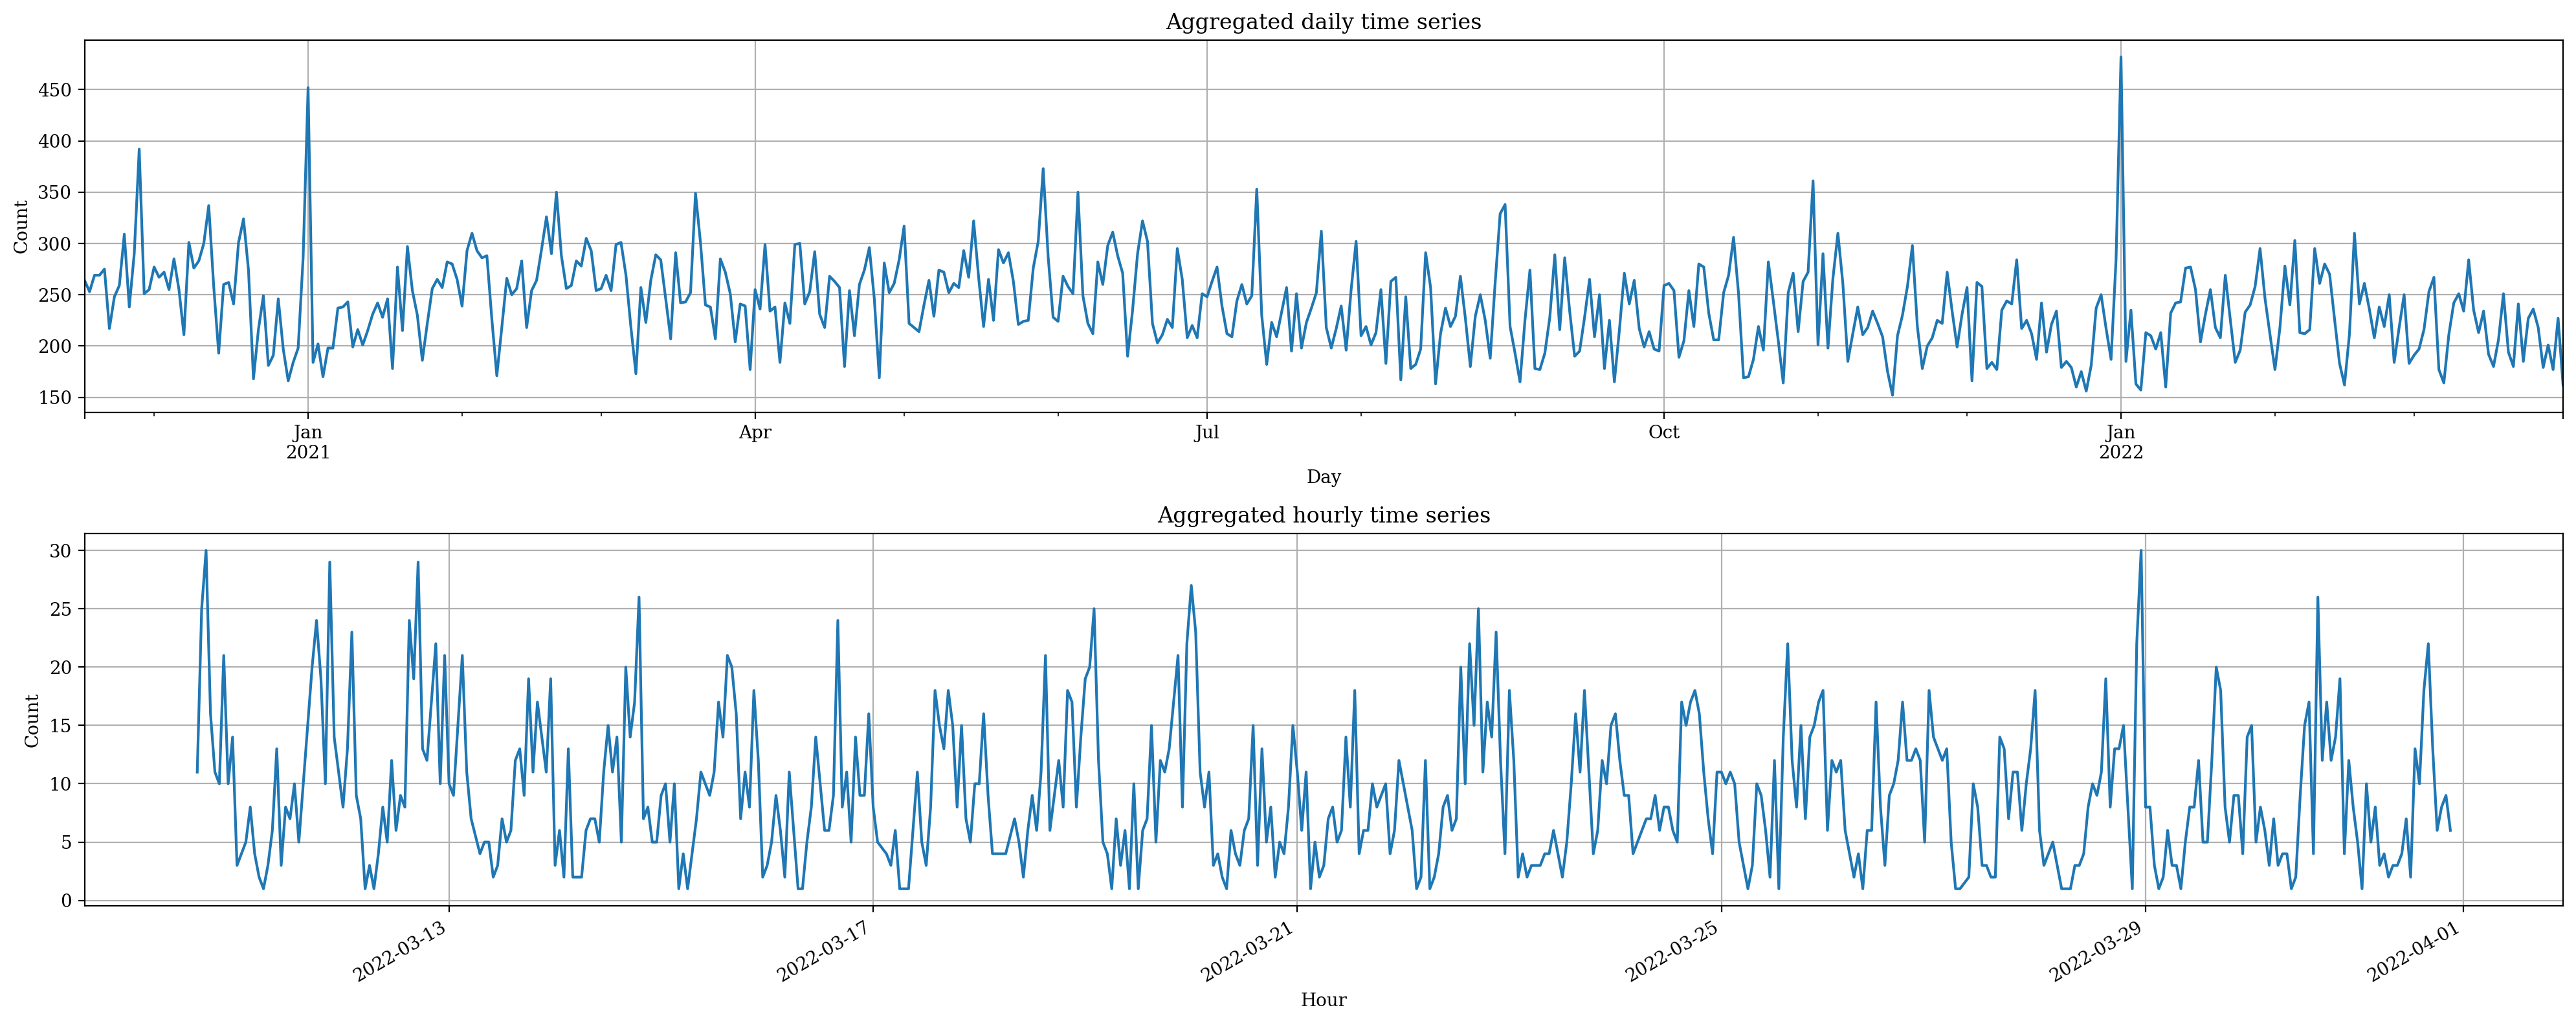

In [4]:
#aggregate all the boroughs into a single time series and plot it

aggregated_data_daily = time_series_daily.groupby('day').sum()
aggregated_data_hourly = time_series_hourly.groupby('hour').sum()

fig, ax = plt.subplots(2, 1, figsize=(20, 8), dpi=200)

aggregated_data_daily['count'][-500:].plot(ax=ax[0])  #limited to the last 500 observations
ax[0].set_title("Aggregated daily time series")
ax[0].set_ylabel("Count")
ax[0].set_xlabel("Day")
ax[0].grid(True)

aggregated_data_hourly['count'][-500:].plot(ax=ax[1]) #limited to the last 500 observations
ax[1].set_title("Aggregated hourly time series")
ax[1].set_ylabel("Count")
ax[1].set_xlabel("Hour")
ax[1].grid(True)

plt.tight_layout()
plt.savefig('aggregated_time_series.png')
plt.show()

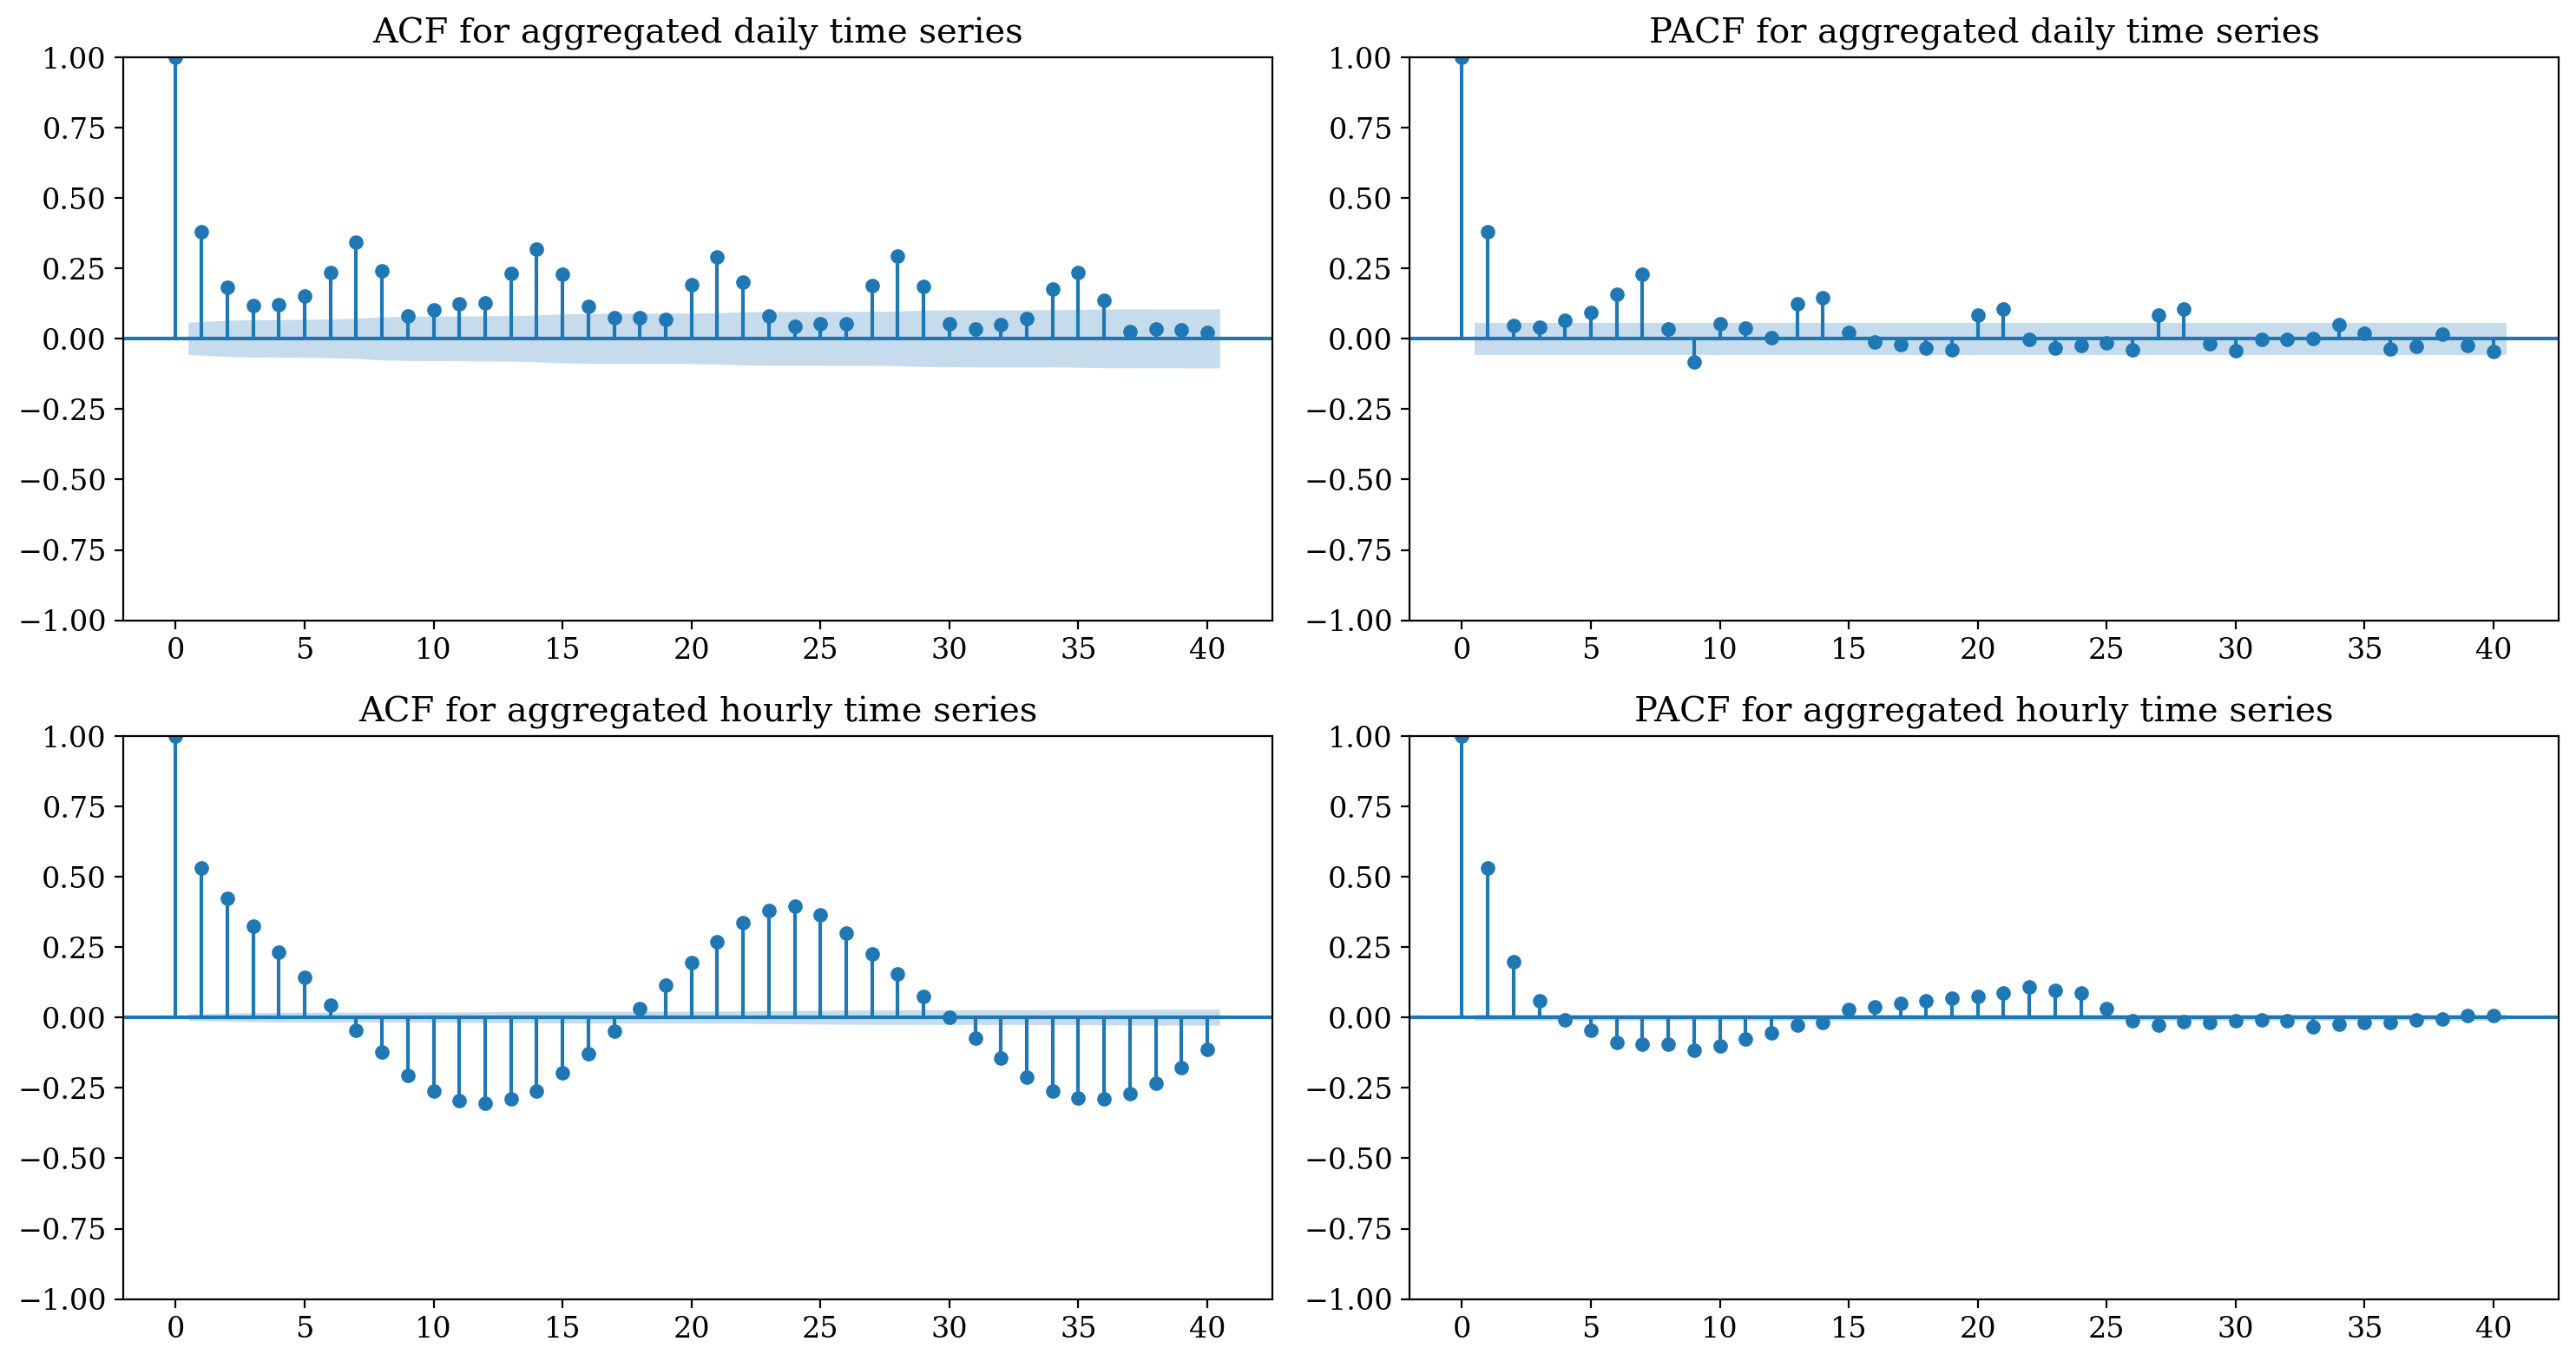

In [21]:
#ACF and PACF for daily and hourly aggregated data
fig, axs = plt.subplots(2, 2, figsize=(15, 8), dpi=200)

sm.graphics.tsa.plot_acf(aggregated_data_daily['count'], lags=40, ax=axs[0, 0])
axs[0, 0].set_title("ACF for aggregated daily time series")
sm.graphics.tsa.plot_pacf(aggregated_data_daily['count'], lags=40, ax=axs[0, 1])
axs[0, 1].set_title("PACF for aggregated daily time series")

sm.graphics.tsa.plot_acf(aggregated_data_hourly['count'], lags=40, ax=axs[1, 0])
axs[1, 0].set_title("ACF for aggregated hourly time series")
sm.graphics.tsa.plot_pacf(aggregated_data_hourly['count'], lags=40, ax=axs[1, 1])
axs[1, 1].set_title("PACF for aggregated hourly time series")

plt.tight_layout()
plt.savefig('acf_pacf_aggregated_data.png')
plt.show()